In [1]:
import os 
import sys
import copy
current_file_dir = os.getcwd()

root_dir = os.path.dirname(current_file_dir)

sys.path.append(root_dir)
dataset_dir = os.path.join(root_dir, 'data')

In [2]:
import torch
from torchvision import transforms
import pandas as pd

In [3]:
from src.utils.postprocess import denormalize_image, postprocess_output,visualize_results, visualize_overlay_comparison,visualize_overlay 
from src.utils.preprocess import create_pointcloud_image, create_morphological_polygon
from src.model import UNetModel, UNetConfig, create_unet_model
from src.utils.dataset import MultiViewImageDataset
from src.utils.loss import DiceLoss, FocalLoss, CombinedLoss, IoULoss
from src.utils.metrics import SegmentationMetrics


/home/yasin/Lfstorage/anaconda3/envs/pytorch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yasin/Lfstorage/anaconda3/envs/pytorch/lib/python3.13/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

mask_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),

    transforms.ToTensor(),
])

processed_dataset_dir = os.path.join(dataset_dir, 'processed', 'lidarseg_images')
image_size = (398, 224)

In [5]:
normal_dataset = MultiViewImageDataset(
    root_dir=os.path.join(processed_dataset_dir, 'trainval'),
    input_transform=input_transform,
    mask_transform=mask_transform,
    image_size=image_size)

normal_dataset_df = pd.read_csv(os.path.join(processed_dataset_dir, 'trainval', 'trainval.csv'))

validation = normal_dataset_df[normal_dataset_df['trainable'] == 0]["filename"].tolist()

normal_dataset.update_image_names(validation)


occluded_dataset = MultiViewImageDataset(
    root_dir=os.path.join(processed_dataset_dir, 'occluded'),
    input_transform=input_transform,
    mask_transform=mask_transform,
    image_size=image_size)

occluded_dataset_df = pd.read_csv(os.path.join(processed_dataset_dir, 'occluded', 'trainval.csv'))
occluded_validation = occluded_dataset_df[occluded_dataset_df['trainable'] == 0]["filename"].tolist()
occluded_dataset.update_image_names(occluded_validation)



In [7]:


occuled_data_loader = torch.utils.data.DataLoader(
    occluded_dataset,
    batch_size=6,
    shuffle=False,
    num_workers=16,
)

normal_data_loader = torch.utils.data.DataLoader(
    normal_dataset,
    batch_size=6,
    shuffle=False,
    num_workers=16,
)

In [6]:
pretrained_model_path = os.path.join(root_dir, 'models', 'lidarseg_unet-aug')
model = UNetModel.from_pretrained(pretrained_model_path)

device = "cuda:1"
model.to(device)
model.eval()

UNetModel(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [ ]:

metrics_calculator = SegmentationMetrics(threshold=0.5) 
metrics_calculator.reset()

for batch in normal_data_loader:
    cam = batch['cam'].to(device)
    pointcloud = batch['point_cloud'].to(device)
    inputs = torch.cat((cam, pointcloud), dim=1)
    masks = batch['masked'].to(device)


    with torch.no_grad():
        outputs = model(inputs)

    metrics_calculator.update(outputs, masks)

normal_results = metrics_calculator.compute()

print("Validation Metrics For Both CAMERA + LIDAR Data:")
for metric, value in normal_results.items():
    print(f"{metric}: {value:.4f}")


In [ ]:

metrics_calculator = SegmentationMetrics(threshold=0.5) 


for batch in normal_data_loader:
    cam = batch['cam'].to(device)
    pointcloud = torch.zeros_like(batch['point_cloud']).to(device) 
    inputs = torch.cat((cam, pointcloud), dim=1)
    masks = batch['masked'].to(device)


    with torch.no_grad():
        outputs = model(inputs)

    metrics_calculator.update(outputs, masks)

normal_only_cam_result = metrics_calculator.compute()

print("Validation Metrics For CAMERA Data Only:")
for metric, value in normal_only_cam_result.items():
    print(f"{metric}: {value:.4f}")


In [ ]:

metrics_calculator = SegmentationMetrics(threshold=0.5) 


for batch in normal_data_loader:
    cam = torch.zeros_like(batch['cam']).to(device)
    pointcloud = batch['point_cloud'].to(device)
    inputs = torch.cat((cam, pointcloud), dim=1)
    masks = batch['masked'].to(device)


    with torch.no_grad():
        outputs = model(inputs)

    metrics_calculator.update(outputs, masks)

normal_only_lidar_result = metrics_calculator.compute()

print("Validation Metrics For LIDAR Data Only:")
for metric, value in normal_only_lidar_result.items():
    print(f"{metric}: {value:.4f}")


In [ ]:
metrics_calculator = SegmentationMetrics(threshold=0.5)

for batch in occuled_data_loader:
    cam = batch['cam'].to(device)
    pointcloud = batch['point_cloud'].to(device)
    inputs = torch.cat((cam, pointcloud), dim=1)
    masks = batch['masked'].to(device)

    with torch.no_grad():
        outputs = model(inputs)

    metrics_calculator.update(outputs, masks)
occluded_results = metrics_calculator.compute()
print("Validation Metrics For Occluded CAMERA + LIDAR Data:")
for metric, value in occluded_results.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
results = [
    {"Setting": "Normal (Kamera + Lidar)", **normal_results},
    {"Setting": "Normal (Sadece Kamera)", **normal_only_cam_result},
    {"Setting": "Normal (Sadece Lidar)", **normal_only_lidar_result},
    {"Setting": "Occluded (Kamera + Lidar)", **occluded_results},
]

df = pd.DataFrame(results)
df = df[["Setting", "IoU", "Dice", "Precision", "Recall", "F1", "PixelAcc"]]
df = df.set_index("Setting")


df.to_csv(os.path.join(root_dir, 'docs', 'lidarseg_validation_results.csv'))
print("Validation results saved to lidarseg_validation_results.csv")
print("Validation completed successfully.")

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metric(df, metric, figsize=(8, 6), style='whitegrid', palette='viridis', 
                title_fontsize=14, label_fontsize=12, rotation=30):
    sns.set_style(style)
    plt.figure(figsize=figsize)
    
    ax = sns.barplot(data=df, x='Setting', y=metric, palette=palette)
    
    plt.title(f'{metric} by Setting', fontsize=title_fontsize, fontweight='bold', pad=20)
    plt.xlabel('Setting', fontsize=label_fontsize)
    plt.ylabel(metric, fontsize=label_fontsize)
    
    plt.xticks(rotation=rotation)
    
    plt.ylim(0, 1.0)
    
    plt.grid(True, alpha=0.3)
    
    for i, v in enumerate(df.groupby('Setting')[metric].mean()):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# plot IOU metric
plot_metric(df, 'IoU', figsize=(10, 6), style='whitegrid', palette='viridis', 
            title_fontsize=16, label_fontsize=14, rotation=30)

In [ ]:
#plot Dice metric
plot_metric(df, 'Dice', figsize=(10, 6), style='whitegrid', palette='viridis', 
            title_fontsize=16, label_fontsize=14, rotation=30)

In [ ]:
#plot F1 metric
plot_metric(df, 'F1', figsize=(10, 6), style='whitegrid', palette='viridis', 
            title_fontsize=16, label_fontsize=14, rotation=30)

In [ ]:
# plot Precision metric
plot_metric(df, 'Precision', figsize=(10, 6), style='whitegrid', palette='viridis', 
            title_fontsize=16, label_fontsize=14, rotation=30)

In [ ]:
#plot recall metric
plot_metric(df, 'Recall', figsize=(10, 6), style='whitegrid', palette='viridis', 
            title_fontsize=16, label_fontsize=14, rotation=30)

In [ ]:
#plot PixelAcc metric
plot_metric(df, 'PixelAcc', figsize=(10, 6), style='whitegrid', palette='viridis', 
            title_fontsize=16, label_fontsize=14, rotation=30)

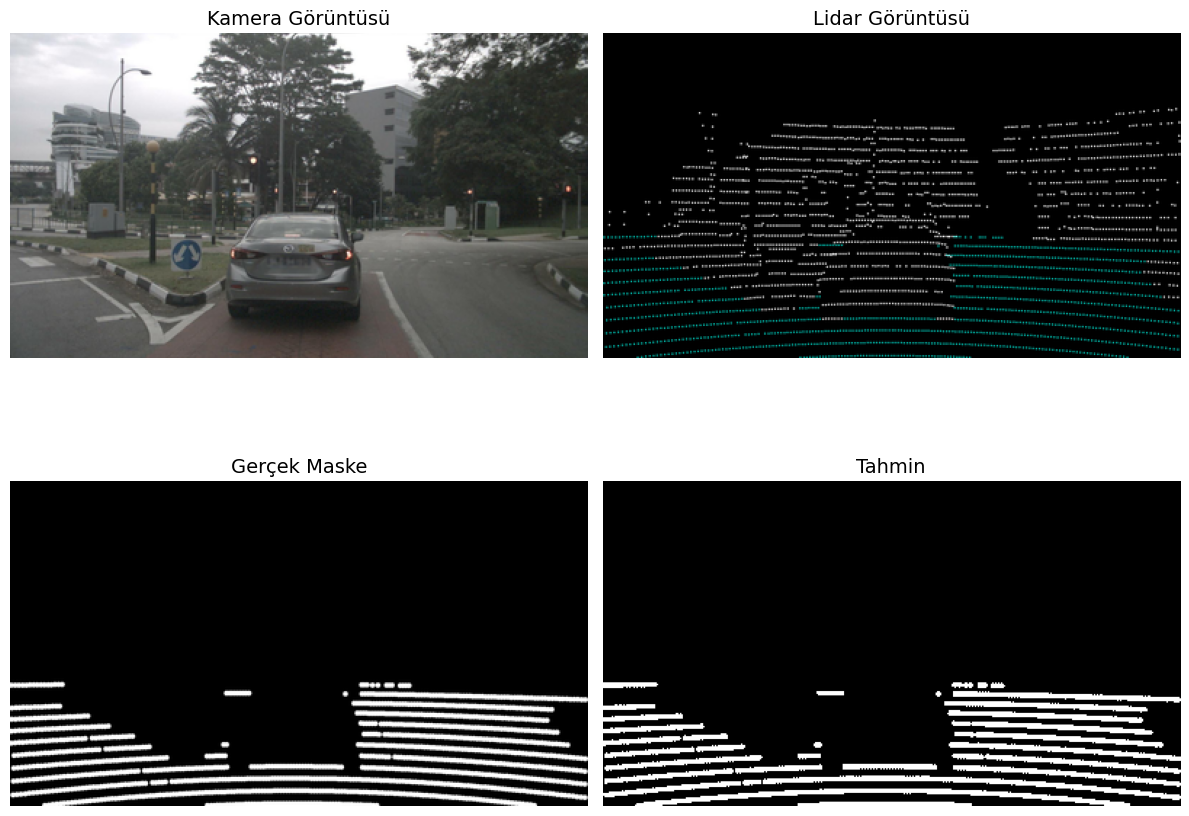

In [8]:
sample_id = 196
mean=(0.5, 0.5, 0.5) 
std=(0.5, 0.5, 0.5)

sample = normal_dataset[sample_id]
cam = sample['cam'].unsqueeze(0).to(device)
pointcloud = sample['point_cloud'].unsqueeze(0).to(device)
inputs = torch.cat((cam, pointcloud), dim=1)
with torch.no_grad():
    output = model(inputs)
output = torch.sigmoid(output).squeeze(0).cpu().numpy()
mask = sample['masked'].squeeze(0).cpu().numpy()

# Output'u resme çevir
output_image = postprocess_output(output, output_type='mask')

# Denormalize et
denormalized_cam = denormalize_image(sample['cam'], mean=mean, std=std)
denormalized_pointcloud = denormalize_image(sample['point_cloud'], mean=mean, std=std)

# Görselleştir
visualize_results(denormalized_cam, denormalized_pointcloud, mask, output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..127.0].


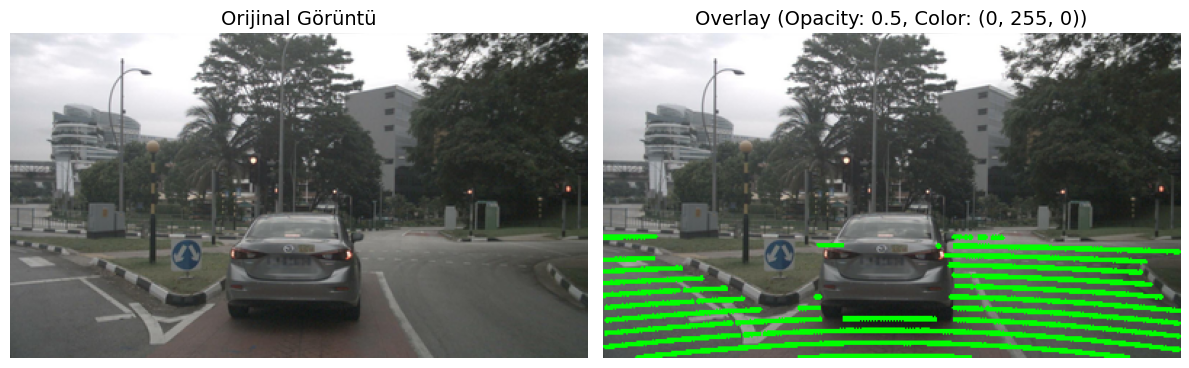

array([[[0.81960785, 0.82352942, 0.84313726],
        [0.81960785, 0.82352942, 0.84313726],
        [0.81960785, 0.82352942, 0.84313726],
        ...,
        [0.52549022, 0.54509807, 0.51764709],
        [0.6156863 , 0.63137257, 0.63137257],
        [0.56470591, 0.57647061, 0.59215689]],

       [[0.8392157 , 0.84313726, 0.86274511],
        [0.84705883, 0.8509804 , 0.87058824],
        [0.84705883, 0.8509804 , 0.87058824],
        ...,
        [0.49803922, 0.51764709, 0.50196081],
        [0.50588238, 0.52156866, 0.51764709],
        [0.44705883, 0.4627451 , 0.4627451 ]],

       [[0.85490197, 0.85882354, 0.87843138],
        [0.86274511, 0.86666667, 0.88627452],
        [0.87058824, 0.87450981, 0.89411765],
        ...,
        [0.29803923, 0.3137255 , 0.30980393],
        [0.29803923, 0.31764707, 0.29803923],
        [0.26274511, 0.28235295, 0.25882354]],

       ...,

       [[0.27058825, 0.28627452, 0.28235295],
        [0.29411766, 0.30980393, 0.30980393],
        [0.27450982, 0

In [9]:
visualize_overlay_comparison(denormalized_cam, output, color = (0,255, 0), opacity=0.5)


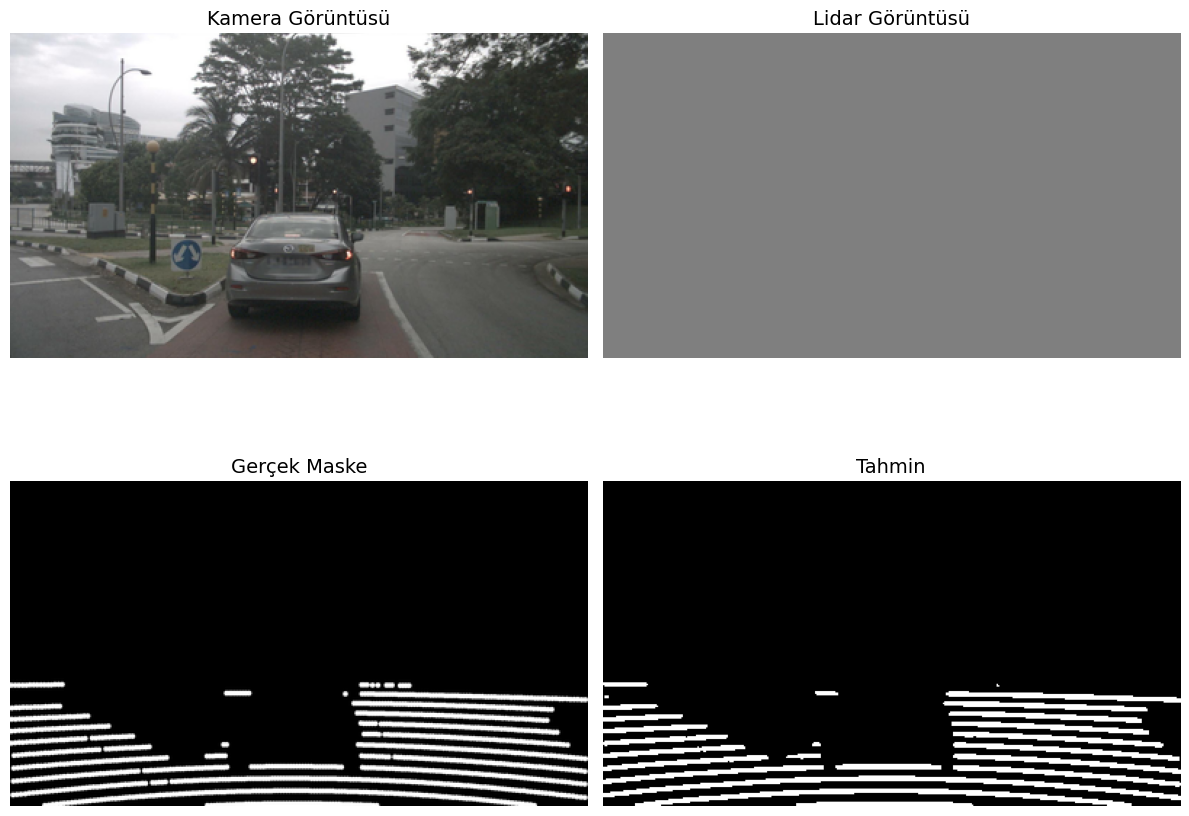

In [10]:
sample_id = 196
mean=(0.5, 0.5, 0.5) 
std=(0.5, 0.5, 0.5)

sample = normal_dataset[sample_id]
cam = sample['cam'].unsqueeze(0).to(device)
pointcloud = torch.zeros_like(sample['point_cloud'].unsqueeze(0).to(device))
inputs = torch.cat((cam, pointcloud), dim=1)
with torch.no_grad():
    output = model(inputs)
output = torch.sigmoid(output).squeeze(0).cpu().numpy()
mask = sample['masked'].squeeze(0).cpu().numpy()

# Output'u resme çevir
output_image = postprocess_output(output, output_type='mask')

# Denormalize et
denormalized_cam = denormalize_image(cam.squeeze(0), mean=mean, std=std)
denormalized_pointcloud = denormalize_image(pointcloud.squeeze(0), mean=mean, std=std)
denormalized_mask = denormalize_image(mask, mean=(0.5,), std=(0.5,))

# Görselleştir
visualize_results(denormalized_cam, denormalized_pointcloud, denormalized_mask, output_image)

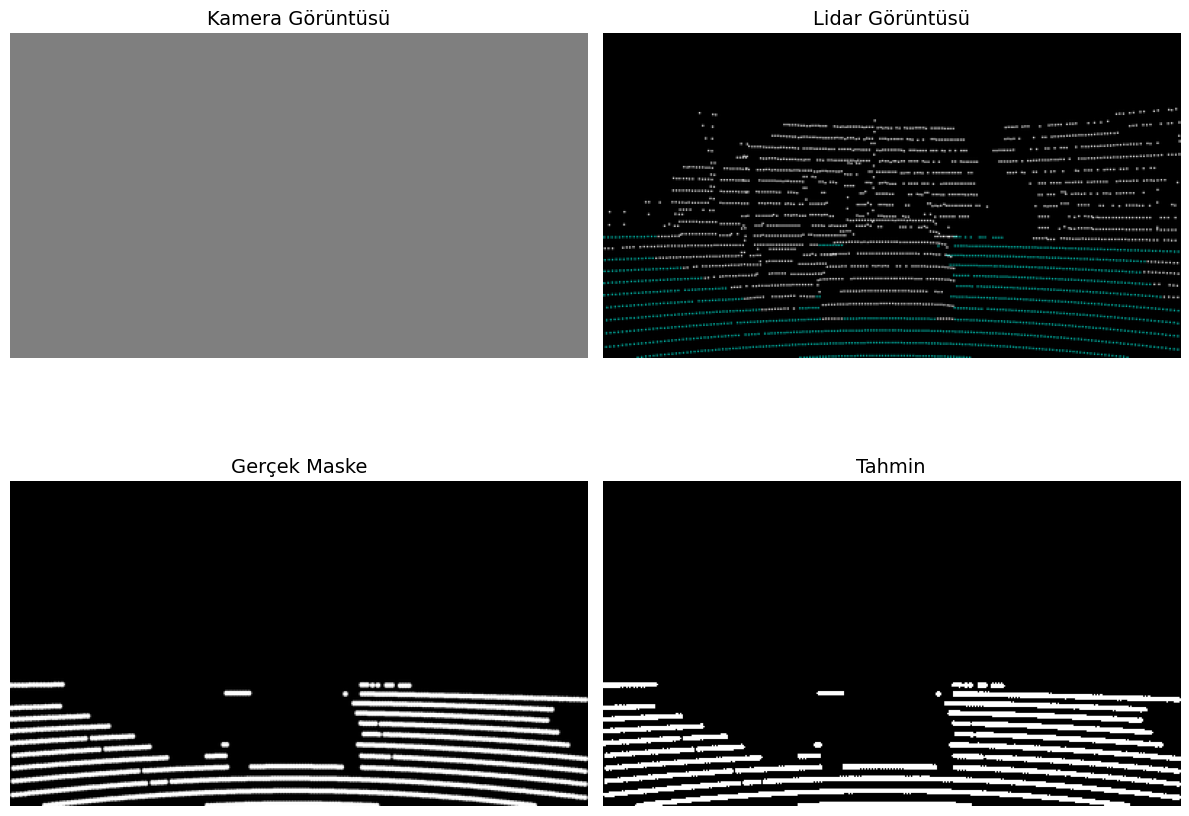

In [11]:
sample_id = 196
mean=(0.5, 0.5, 0.5) 
std=(0.5, 0.5, 0.5)

sample = normal_dataset[sample_id]
cam = torch.zeros_like(sample['cam'].unsqueeze(0).to(device))
pointcloud = sample['point_cloud'].unsqueeze(0).to(device)
inputs = torch.cat((cam, pointcloud), dim=1)
with torch.no_grad():
    output = model(inputs)
output = torch.sigmoid(output).squeeze(0).cpu().numpy()
mask = sample['masked'].squeeze(0).cpu().numpy()

# Output'u resme çevir
output_image = postprocess_output(output, output_type='mask')

# Denormalize et
denormalized_cam = denormalize_image(cam.squeeze(0), mean=mean, std=std)
denormalized_pointcloud = denormalize_image(pointcloud.squeeze(0), mean=mean, std=std)
denormalized_mask = denormalize_image(mask, mean=(0.5,), std=(0.5,))

# Görselleştir
visualize_results(denormalized_cam, denormalized_pointcloud, denormalized_mask, output_image)